<img src="https://nserc-hi-am.ca/2020/wp-content/uploads/sites/18/2019/12/McGill.png" width="500" height="400" align="center">

# Group Project
#### Arnaud Guzman-Annès | ID: 260882529
#### Ram Babu | ID: 260958970
#### Sophie Courtemanche-Martel | ID: 260743568
#### Duncan Wang | ID: 260710229
#### Jules Zielinski | ID: XXXXXXX
<br><br>
**Date: February 22nd, 2021**
<br><br>
## Objective:

TED talks are video recordings of influential talks given at and hosted by TED Conferences LLC. TED was founded in 1984, and has since built a reputation for spreading inspiring powerful ideas in fields ranging from tech to science to education, with its videos having garnered over 1 billion views to date.

The goal of this project is to use various features associated with TED talks -- such as the topic, speaker, conference year, and length of the talk -- to predict the number of views a TED talk may receive.


# I - Data preprocessing

## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed as well as Scikit-Learn (V ≥0.20).

In [33]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get the data

## From GitHub repository

In [34]:
import pandas as pd
import requests
import io
    
# Downloading the csv file from my GitHub account
url = "https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/TED/main/data/ted_main.csv"

download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe
# We will use "churn" instead of "df" for replication purposes
df = pd.read_csv(io.StringIO(download.decode('utf-8')))

# Printing out the first 5 rows of the dataframe
df.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869


# Data preprocesing

## About the dataset

* **name:** The official name of the TED Talk. Includes the title and the speaker.
* **title:** The title of the talk
* **description:** A blurb of what the talk is about.
* **main_speaker:** The first named speaker of the talk.
* **speaker_occupation:** The occupation of the main speaker.
* **num_speaker:** The number of speakers in the talk.
* **duration:** The duration of the talk in seconds.
* **event:** The TED/TEDx event where the talk took place.
* **film_date:** The Unix timestamp of the filming.
* **published_date:** The Unix timestamp for the publication of the talk on TED.com
* **comments:** The number of first level comments made on the talk.
* **tags:** The themes associated with the talk.
* **languages:** The number of languages in which the talk is available.
* **ratings:** A stringified dictionary of the various ratings given to the talk (inspiring, fascinating, jaw dropping, etc.)
* **related_talks:** A list of dictionaries of recommended talks to watch next.
* **url:** The URL of the talk.
* **views:** The number of views on the talk.

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comments            2550 non-null   int64 
 1   description         2550 non-null   object
 2   duration            2550 non-null   int64 
 3   event               2550 non-null   object
 4   film_date           2550 non-null   int64 
 5   languages           2550 non-null   int64 
 6   main_speaker        2550 non-null   object
 7   name                2550 non-null   object
 8   num_speaker         2550 non-null   int64 
 9   published_date      2550 non-null   int64 
 10  ratings             2550 non-null   object
 11  related_talks       2550 non-null   object
 12  speaker_occupation  2544 non-null   object
 13  tags                2550 non-null   object
 14  title               2550 non-null   object
 15  url                 2550 non-null   object
 16  views               2550

In [36]:
# Reorganize the columns for a better visualization

df = df[['name', 'title', 'description', 'main_speaker', 'speaker_occupation', 'num_speaker', 'duration', 'event', 'film_date', 'published_date', 'comments', 'tags', 'languages', 'ratings', 'related_talks', 'url', 'views']]
df.head()

,name,title,description,main_speaker,speaker_occupation,num_speaker,duration,event,film_date,published_date,comments,tags,languages,ratings,related_talks,url,views
0,Ken Robinson: Do schools kill creativity?,Do schools kill creativity?,Sir Ken Robinson makes an entertaining and pro...,Ken Robinson,Author/educator,1,1164,TED2006,1140825600,1151367060,4553,"['children', 'creativity', 'culture', 'dance',...",60,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,Al Gore: Averting the climate crisis,Averting the climate crisis,With the same humor and humanity he exuded in ...,Al Gore,Climate advocate,1,977,TED2006,1140825600,1151367060,265,"['alternative energy', 'cars', 'climate change...",43,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",https://www.ted.com/talks/al_gore_on_averting_...,3200520
2,David Pogue: Simplicity sells,Simplicity sells,New York Times columnist David Pogue takes aim...,David Pogue,Technology columnist,1,1286,TED2006,1140739200,1151367060,124,"['computers', 'entertainment', 'interface desi...",26,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",https://www.ted.com/talks/david_pogue_says_sim...,1636292
3,Majora Carter: Greening the ghetto,Greening the ghetto,"In an emotionally charged talk, MacArthur-winn...",Majora Carter,Activist for environmental justice,1,1116,TED2006,1140912000,1151367060,200,"['MacArthur grant', 'activism', 'business', 'c...",35,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",https://www.ted.com/talks/majora_carter_s_tale...,1697550
4,Hans Rosling: The best stats you've ever seen,The best stats you've ever seen,You've never seen data presented like this. Wi...,Hans Rosling,Global health expert; data visionary,1,1190,TED2006,1140566400,1151440680,593,"['Africa', 'Asia', 'Google', 'demo', 'economic...",48,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",https://www.ted.com/talks/hans_rosling_shows_t...,12005869


In [37]:
# Some more information about the dataset

display(df.shape)
display(df.isnull().sum())
display(df.describe())

(2550, 17)

name                  0
title                 0
description           0
main_speaker          0
speaker_occupation    6
num_speaker           0
duration              0
event                 0
film_date             0
published_date        0
comments              0
tags                  0
languages             0
ratings               0
related_talks         0
url                   0
views                 0
dtype: int64

,num_speaker,duration,film_date,published_date,comments,languages,views
count,2550.000000,2550.000000,2.550000e+03,2.550000e+03,2550.000000,2550.000000,2.550000e+03
mean,1.028235,826.510196,1.321928e+09,1.343525e+09,191.562353,27.326275,1.698297e+06
std,0.207705,374.009138,1.197391e+08,9.464009e+07,282.315223,9.563452,2.498479e+06
min,1.000000,135.000000,7.464960e+07,1.151367e+09,2.000000,0.000000,5.044300e+04
25%,1.000000,577.000000,1.257466e+09,1.268463e+09,63.000000,23.000000,7.557928e+05
50%,1.000000,848.000000,1.333238e+09,1.340935e+09,118.000000,28.000000,1.124524e+06
75%,1.000000,1046.750000,1.412964e+09,1.423432e+09,221.750000,33.000000,1.700760e+06
max,5.000000,5256.000000,1.503792e+09,1.506092e+09,6404.000000,72.000000,4.722711e+07


## Observations

- There are 2550 rows and 17 columns.
- `speaker_occupation` column have 6 missing values.

In [38]:
# working on df_copy for the rest of data exploration

df_copy = df.copy()

In [39]:
# Filtering out the TED talks
df_copy = df_copy[df_copy['event'].str.contains('TED', regex=False, case=False, na=False)]
df_copy.shape

(2439, 17)

In [40]:
df_copy = df_copy.drop(["description","url"],axis=1)

In [41]:
# Converting Duration to minutes
df_copy["duration"] = round(df_copy["duration"]/60,2)

In [42]:
df_copy.fillna('Unknown', inplace = True)

In [43]:
df_copy['languages'].describe()

count    2439.000000
mean       27.703977
std         9.205526
min         0.000000
25%        23.000000
50%        28.000000
75%        33.000000
max        72.000000
Name: languages, dtype: float64

Observations with zero languages are musicals

In [44]:
df_copy[df_copy['languages'] == 0]

,name,title,main_speaker,speaker_occupation,num_speaker,duration,event,film_date,published_date,comments,tags,languages,ratings,related_talks,views
58,"Pilobolus: A dance of ""Symbiosis""","A dance of ""Symbiosis""",Pilobolus,Dance company,1,13.75,TED2005,1109289600,1170979860,222,"['dance', 'entertainment', 'nature', 'performa...",0,"[{'id': 1, 'name': 'Beautiful', 'count': 1810}...","[{'id': 40, 'hero': 'https://pe.tedcdn.com/ima...",3051507
115,"Ethel: A string quartet plays ""Blue Room""","A string quartet plays ""Blue Room""",Ethel,String quartet,1,3.57,TED2006,1138838400,1182184140,27,"['cello', 'collaboration', 'culture', 'enterta...",0,"[{'id': 1, 'name': 'Beautiful', 'count': 216},...","[{'id': 103, 'hero': 'https://pe.tedcdn.com/im...",384641
135,"Vusi Mahlasela: ""Woza""","""Woza""",Vusi Mahlasela,"Musician, activist",1,4.98,TEDGlobal 2007,1181260800,1187695440,36,"['Africa', 'entertainment', 'guitar', 'live mu...",0,"[{'id': 8, 'name': 'Informative', 'count': 4},...","[{'id': 158, 'hero': 'https://pe.tedcdn.com/im...",416603
209,"Rokia Traore: ""M'Bifo""","""M'Bifo""",Rokia Traore,Singer-songwriter,1,6.98,TEDGlobal 2007,1181088000,1206580680,67,"['Africa', 'entertainment', 'guitar', 'live mu...",0,"[{'id': 23, 'name': 'Jaw-dropping', 'count': 5...","[{'id': 265, 'hero': 'https://pe.tedcdn.com/im...",294936
237,"Rokia Traore: ""Kounandi""","""Kounandi""",Rokia Traore,Singer-songwriter,1,6.43,TEDGlobal 2007,1181088000,1212627600,43,"['Africa', 'guitar', 'live music', 'music', 's...",0,"[{'id': 22, 'name': 'Fascinating', 'count': 84...","[{'id': 186, 'hero': 'https://pe.tedcdn.com/im...",82488
249,Sxip Shirey + Rachelle Garniez: A performance ...,"A performance with breath, music, passion",Sxip Shirey + Rachelle Garniez,Musician,2,3.10,TED2008,1202774400,1214787600,50,"['entertainment', 'live music', 'music']",0,"[{'id': 9, 'name': 'Ingenious', 'count': 44}, ...","[{'id': 115, 'hero': 'https://pe.tedcdn.com/im...",217663
399,Eric Lewis: Piano jazz that rocks,Piano jazz that rocks,Eric Lewis,Pianist,1,10.60,TED2009,1233878400,1236301200,194,"['entertainment', 'innovation', 'invention', '...",0,"[{'id': 21, 'name': 'Unconvincing', 'count': 8...","[{'id': 46, 'hero': 'https://pe.tedcdn.com/ima...",697257
446,Eric Lewis: Chaos and harmony on piano,Chaos and harmony on piano,Eric Lewis,Pianist,1,4.90,TED2009,1233792000,1242090000,138,"['art', 'entertainment', 'live music', 'music'...",0,"[{'id': 26, 'name': 'Obnoxious', 'count': 84},...","[{'id': 478, 'hero': 'https://pe.tedcdn.com/im...",391427
474,Qi Zhang: An electrifying organ performance,An electrifying organ performance,Qi Zhang,Organist,1,3.08,TEDxUSC,1237766400,1245401400,135,"['TEDx', 'china', 'music', 'performance', 'pia...",0,"[{'id': 23, 'name': 'Jaw-dropping', 'count': 3...","[{'id': 46, 'hero': 'https://pe.tedcdn.com/ima...",803691
512,Vishal Vaid: Hypnotic South Asian improv music,Hypnotic South Asian improv music,Vishal Vaid,Musician,1,13.57,TED2006,1139443200,1252630800,146,"['Asia', 'beauty', 'culture', 'history', 'musi...",0,"[{'id': 25, 'name': 'OK', 'count': 68}, {'id':...","[{'id': 581, 'hero': 'https://pe.tedcdn.com/im...",414396


In [45]:
#Indexing the rows
df_copy.reset_index(inplace=True)

In [46]:
from collections import defaultdict
rating_data = defaultdict(list)

In [47]:
import ast
rating_names = set()
for index, row in df_copy.iterrows():
    rating = ast.literal_eval(row['ratings'])
    for item in rating:
        rating_names.add(item['name'])

In [48]:
rating_names

{'Beautiful',
 'Confusing',
 'Courageous',
 'Fascinating',
 'Funny',
 'Informative',
 'Ingenious',
 'Inspiring',
 'Jaw-dropping',
 'Longwinded',
 'OK',
 'Obnoxious',
 'Persuasive',
 'Unconvincing'}

In [49]:
#Extracting ratings

rating_data = defaultdict(list)
for index, row in df_copy.iterrows():
    rating = ast.literal_eval(row['ratings'])
    rating_data['ID'].append(row['index'])
    names = set()
    for item in rating:
        rating_data[item['name']].append(item['count'])
        names.add(item['name'])

rating_data = pd.DataFrame(rating_data)

rating_data.head()

,ID,Funny,Beautiful,Ingenious,Courageous,Longwinded,Confusing,Informative,Fascinating,Unconvincing,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring
0,0,19645,4573,6073,3253,387,242,7346,10581,300,10704,4439,1174,209,24924
1,1,544,58,56,139,113,62,443,132,258,268,116,203,131,413
2,2,964,60,183,45,78,27,395,166,104,230,54,146,142,230
3,3,59,291,105,760,53,32,380,132,36,460,230,85,35,1070
4,4,1390,942,3202,318,110,72,5433,4606,67,2542,3736,248,61,2893


In [50]:
# Extracting tags

tags_data = defaultdict(list)
for index, row in df_copy.iterrows():
    tags = ast.literal_eval(row['tags'])
    for item in tags:
        tags_data['ID'].append(row['index'])
        tags_data['tags'].append(item)

tags_data = pd.DataFrame(tags_data)

In [51]:
tags_data[tags_data['ID']==1]

,ID,tags
7,1,alternative energy
8,1,cars
9,1,climate change
10,1,culture
11,1,environment
12,1,global issues
13,1,science
14,1,sustainability
15,1,technology


In [52]:
# Extracting related talks

df_copy['related_views'] = 0
df_copy['related_duration'] = 0
for index, row in df_copy.iterrows():
    rel = row['related_talks'].split(',')
    ctr1 = 0
    tot1 = 0
    ctr2 = 0
    tot2 = 0
    for views in rel:
        if 'viewed_count' in views:
            view = views.split(':')
            view[1] = view[1].replace("]", "")
            view[1] = view[1].replace(" ", "")
            view[1] = view[1].replace("}", "")
            tot1+=int(view[1])
            ctr1+=1
        if 'duration' in views:
            view = views.split(':')
            view[1] = view[1].replace("]", "")
            view[1] = view[1].replace(" ", "")
            view[1] = view[1].replace("}", "")
            tot2+=int(view[1])
            ctr2+=1
    df_copy['related_views'][index] = tot1/ctr1
    df_copy['related_duration'][index] = tot2/ctr2

C:\Users\Jules\anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Jules\anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [53]:
df_copy.head()

,index,name,title,main_speaker,speaker_occupation,num_speaker,duration,event,film_date,published_date,comments,tags,languages,ratings,related_talks,views,related_views,related_duration
0,0,Ken Robinson: Do schools kill creativity?,Do schools kill creativity?,Ken Robinson,Author/educator,1,19.40,TED2006,1140825600,1151367060,4553,"['children', 'creativity', 'culture', 'dance',...",60,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",47227110,3027062,921
1,1,Al Gore: Averting the climate crisis,Averting the climate crisis,Al Gore,Climate advocate,1,16.28,TED2006,1140825600,1151367060,265,"['alternative energy', 'cars', 'climate change...",43,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",3200520,1118767,1096
2,2,David Pogue: Simplicity sells,Simplicity sells,David Pogue,Technology columnist,1,21.43,TED2006,1140739200,1151367060,124,"['computers', 'entertainment', 'interface desi...",26,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",1636292,1846195,915
3,3,Majora Carter: Greening the ghetto,Greening the ghetto,Majora Carter,Activist for environmental justice,1,18.60,TED2006,1140912000,1151367060,200,"['MacArthur grant', 'activism', 'business', 'c...",35,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",1697550,776189,748
4,4,Hans Rosling: The best stats you've ever seen,The best stats you've ever seen,Hans Rosling,Global health expert; data visionary,1,19.83,TED2006,1140566400,1151440680,593,"['Africa', 'Asia', 'Google', 'demo', 'economic...",48,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",12005869,1907337,943


In [54]:
df_copy['event_category'] = 'Other'

for i in range(len(df_copy)):
    if df_copy['event'][i][0:5]=='TED20':
        df_copy['event_category'][i] = 'TED2000s'
    elif df_copy['event'][i][0:5]=='TED19':
        df_copy['event_category'][i] = 'TED1900s'
    elif df_copy['event'][i][0:4]=='TEDx':
        df_copy['event_category'][i] = "TEDx"
    elif df_copy['event'][i][0:7]=='TED@BCG':
        df_copy['event_category'][i] = 'TED@BCG'
    elif df_copy['event'][i][0:4]=='TED@':
        df_copy['event_category'][i] = "TED@"
    elif df_copy['event'][i][0:8]=='TEDSalon':
        df_copy['event_category'][i] = "TEDSalon"
    elif df_copy['event'][i][0:9]=='TEDGlobal':
        df_copy['event_category'][i] = 'TEDGlobal'
    elif df_copy['event'][i][0:8]=='TEDWomen':
        df_copy['event_category'][i] = 'TEDWomen'
    elif df_copy['event'][i][0:6]=='TEDMED':
        df_copy['event_category'][i] = 'TEDMED'
    elif df_copy['event'][i][0:3]=='TED':
        df_copy['event_category'][i] = 'TEDOther'

C:\Users\Jules\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Jules\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Jules\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\Jules\anaconda3\lib\site-packages\ipykernel_l

In [55]:
# Convert timestamp into readable format

import datetime

df_copy['published_date'] = df_copy['published_date'].apply(lambda x: datetime.date.fromtimestamp(int(x)))
df_copy['day'] = df_copy['published_date'].apply(lambda x: x.weekday())
df_copy['month'] = df_copy['published_date'].apply(lambda x: x.month)
df_copy['year'] = df_copy['published_date'].apply(lambda x: x.year)
df_copy['film_date'] = df_copy['film_date'].apply(lambda x: datetime.date.fromtimestamp(int(x)))
df_copy['day_film'] = df_copy['film_date'].apply(lambda x: x.weekday())
df_copy['month_film'] = df_copy['film_date'].apply(lambda x: x.month)
df_copy['year_film'] = df_copy['film_date'].apply(lambda x: x.year)

In [56]:
to_cat = {"day":   {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thurday", 4: "Friday", 5: "Saturday",
                    6: "Sunday" },
          "day_film":   {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thurday", 4: "Friday", 5: "Saturday",
                    6: "Sunday" }}

df_copy.replace(to_cat, inplace=True)

In [57]:
df_copy.head()

,index,name,title,main_speaker,speaker_occupation,num_speaker,duration,event,film_date,published_date,...,views,related_views,related_duration,event_category,day,month,year,day_film,month_film,year_film
0,0,Ken Robinson: Do schools kill creativity?,Do schools kill creativity?,Ken Robinson,Author/educator,1,19.40,TED2006,2006-02-24,2006-06-26,...,47227110,3027062,921,TED2000s,Monday,6,2006,Friday,2,2006
1,1,Al Gore: Averting the climate crisis,Averting the climate crisis,Al Gore,Climate advocate,1,16.28,TED2006,2006-02-24,2006-06-26,...,3200520,1118767,1096,TED2000s,Monday,6,2006,Friday,2,2006
2,2,David Pogue: Simplicity sells,Simplicity sells,David Pogue,Technology columnist,1,21.43,TED2006,2006-02-23,2006-06-26,...,1636292,1846195,915,TED2000s,Monday,6,2006,Thurday,2,2006
3,3,Majora Carter: Greening the ghetto,Greening the ghetto,Majora Carter,Activist for environmental justice,1,18.60,TED2006,2006-02-25,2006-06-26,...,1697550,776189,748,TED2000s,Monday,6,2006,Saturday,2,2006
4,4,Hans Rosling: The best stats you've ever seen,The best stats you've ever seen,Hans Rosling,Global health expert; data visionary,1,19.83,TED2006,2006-02-21,2006-06-27,...,12005869,1907337,943,TED2000s,Tuesday,6,2006,Tuesday,2,2006


In [58]:
temp = tags_data.groupby(['tags']).count()
temp = temp.sort_values(by='ID',ascending=False)

In [59]:
temp.head(60)

,ID
tags,
technology,701
science,534
global issues,478
culture,473
TEDx,450
design,397
business,332
entertainment,276
health,233


In [60]:
# Creating Tag Categories

df_copy['Technology/Science'] = 0
df_copy['Humanity'] = 0
df_copy['Global Issues'] = 0
df_copy['Art/Creativity'] = 0
df_copy['Business'] = 0
df_copy['Entertainment'] = 0
df_copy['Health'] = 0
df_copy['Communication'] = 0
df_copy['Education']=0

Tech = ['technology','future','comuters','science','invention','research']
Humanity = ['community','society','social change','humanity','culture']
Global_Issues = ['global issues','activism','politics','inequality','environment','climate change']
Art = ['design','art','innovation','creativity','brain']
Business = ['business','economics']
Entertainment = ['entertainment','media','sports']
Health = ['health','biollogy','medicine','health care','medical research']
Communication = ['communication','collaboration']
Education = ['children','education','teaching','parenting']


for i in range(len(tags_data)):
    index = tags_data['ID'][i]
    if tags_data['tags'][i] in Tech:
        df_copy['Technology/Science'][index]=1
    if tags_data['tags'][i] in Humanity:
        df_copy['Humanity'][index]=1
    if tags_data['tags'][i] in Global_Issues:
        df_copy['Global Issues'][index]=1
    if tags_data['tags'][i] in Art:
        df_copy['Art/Creativity'][index]=1
    if tags_data['tags'][i] in Business:
        df_copy['Business'][index]=1
    if tags_data['tags'][i] in Entertainment:
        df_copy['Entertainment'][index]=1
    if tags_data['tags'][i] in Health:
        df_copy['Health'][index]=1
    if tags_data['tags'][i] in Communication:
        df_copy['Communication'][index]=1
    if tags_data['tags'][i] in Education:
        df_copy['Education'][index]=1

C:\Users\Jules\anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Jules\anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Jules\anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Jules\anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A valu

In [61]:
df_copy = df_copy.drop(['index','comments', 'event', 'film_date', 'main_speaker', 'name', 'published_date', 'ratings', 
           'related_talks', 'tags', 'title','speaker_occupation'], 1)

In [62]:
df_copy.head()

,num_speaker,duration,languages,views,related_views,related_duration,event_category,day,month,year,...,year_film,Technology/Science,Humanity,Global Issues,Art/Creativity,Business,Entertainment,Health,Communication,Education
0,1,19.40,60,47227110,3027062,921,TED2000s,Monday,6,2006,...,2006,0,1,0,1,0,0,0,0,1
1,1,16.28,43,3200520,1118767,1096,TED2000s,Monday,6,2006,...,2006,1,1,1,0,0,0,0,0,0
2,1,21.43,26,1636292,1846195,915,TED2000s,Monday,6,2006,...,2006,1,0,0,0,0,1,0,0,0
3,1,18.60,35,1697550,776189,748,TED2000s,Monday,6,2006,...,2006,0,0,1,0,1,0,0,0,0
4,1,19.83,48,12005869,1907337,943,TED2000s,Tuesday,6,2006,...,2006,0,0,1,0,1,0,1,0,0


In [63]:
#### Not wroking
'''
import pandas_profiling
from pandas_profiling import ProfileReport
profile = ProfileReport(df_copy, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile
'''
#### Not wroking

"\nimport pandas_profiling\nfrom pandas_profiling import ProfileReport\nprofile = ProfileReport(df_copy, title='Pandas Profiling Report', html={'style':{'full_width':True}})\nprofile\n"

---

# II - Preparing data for Machine Learning Algorithms

Due to the nature of the dataset, we decided to use a time based cross validation approach. The data itself is not time-series but still has a time dimension aspect (the date of the Ted Talk itself) which can be quite insightful for the current model we are building. 

With the evolving popularity, environment, and subjects of TedTalks, it is best to use time-based splitting to build statistically robust models and follow up with time based cross validations to evaluate the performance of our final model. 

The basis of the splits for the train and test data will be the year of release, with consideration with the amount of talks in each year to ensure a 80% and 20% split for training and test, respectively. 

###### References:  (which we can add at the end when we are done)<br>
+ https://medium.com/eatpredlove/time-series-cross-validation-a-walk-forward-approach-in-python-8534dd1db51a <br>
+ https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8
+ https://medium.com/keita-starts-data-science/time-series-split-with-scikit-learn-74f5be38489e

In [64]:
df_copy.head()

,num_speaker,duration,languages,views,related_views,related_duration,event_category,day,month,year,...,year_film,Technology/Science,Humanity,Global Issues,Art/Creativity,Business,Entertainment,Health,Communication,Education
0,1,19.40,60,47227110,3027062,921,TED2000s,Monday,6,2006,...,2006,0,1,0,1,0,0,0,0,1
1,1,16.28,43,3200520,1118767,1096,TED2000s,Monday,6,2006,...,2006,1,1,1,0,0,0,0,0,0
2,1,21.43,26,1636292,1846195,915,TED2000s,Monday,6,2006,...,2006,1,0,0,0,0,1,0,0,0
3,1,18.60,35,1697550,776189,748,TED2000s,Monday,6,2006,...,2006,0,0,1,0,1,0,0,0,0
4,1,19.83,48,12005869,1907337,943,TED2000s,Tuesday,6,2006,...,2006,0,0,1,0,1,0,1,0,0


In [65]:
df_copy.year.value_counts().sort_index()

2006     50
2007    121
2008    162
2009    205
2010    216
2011    248
2012    303
2013    243
2014    240
2015    215
2016    239
2017    197
Name: year, dtype: int64

In [66]:
df_copy.count()

num_speaker           2439
duration              2439
languages             2439
views                 2439
related_views         2439
related_duration      2439
event_category        2439
day                   2439
month                 2439
year                  2439
day_film              2439
month_film            2439
year_film             2439
Technology/Science    2439
Humanity              2439
Global Issues         2439
Art/Creativity        2439
Business              2439
Entertainment         2439
Health                2439
Communication         2439
Education             2439
dtype: int64

#### First split: Trainning data for model building and cross validation and Test or "New data" -- data only used for final model evaluation

+ Total number of observations: 2439
+ Train (80%) = roughly 1952 observations
+ Test (20%) = roughly 486 observations

Thus, based on the number of observations from each year, the first split will be 
+ Train : Ted Talks from 2006 until 2015 (2003 observations)
+ Test: Ted Talks from 2016 and 2017 (436 observations)


#### Second split: Data for model building and cross validation
+ Total number of observations of the train set : 2003 observations
+ Train 2 set split (80%) : Ted talks from 2006 - 2013 (1548 observations)
+ Test 2 set split (20%) : Ted talks from 2014 - 2015 (455 observations) 


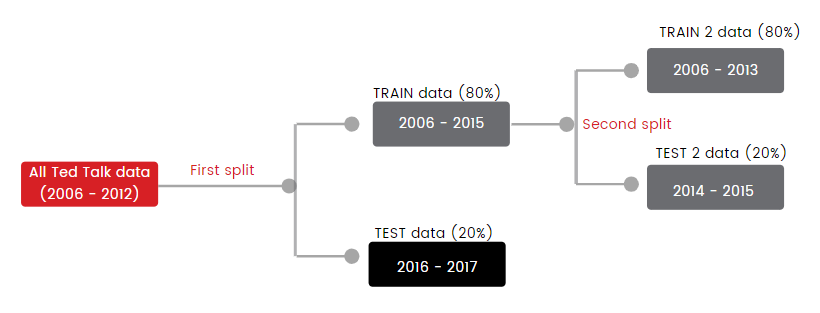

#### First split :

In [67]:
#Train data that will further be split into train and test for model building and evaluation
train_set = df_copy[(df_copy["year"] >= 2006) & (df_copy["year"] <= 2015)]

# Test data ("new data") -- will only be used for final model evaluation
test_set = df_copy[(df_copy["year"]) >= 2016]                                                 

In [68]:
train_copy = train_set.copy()

In [69]:
train_labels = train_copy['views'].copy()
train_copy = train_copy.drop(["views"], axis=1)

#### Second split : Data for model building and cross validation

In [70]:
# trainning data for the different models that will be tested
train_2_set = train_copy[(train_copy["year"] >= 2006) & (train_copy["year"] <= 2013)]

# test data that will be use to evaluate all tested models
test_2_set = train_copy[(train_copy["year"]) >= 2014]     

In [71]:
train_2_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1548 entries, 0 to 1547
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num_speaker         1548 non-null   int64  
 1   duration            1548 non-null   float64
 2   languages           1548 non-null   int64  
 3   related_views       1548 non-null   int64  
 4   related_duration    1548 non-null   int64  
 5   event_category      1548 non-null   object 
 6   day                 1548 non-null   object 
 7   month               1548 non-null   int64  
 8   year                1548 non-null   int64  
 9   day_film            1548 non-null   object 
 10  month_film          1548 non-null   int64  
 11  year_film           1548 non-null   int64  
 12  Technology/Science  1548 non-null   int64  
 13  Humanity            1548 non-null   int64  
 14  Global Issues       1548 non-null   int64  
 15  Art/Creativity      1548 non-null   int64  
 16  Busine

In [72]:
train_num = train_2_set.drop(["event_category","day","month","day_film","month_film"], axis=1)
train_cat = train_2_set[["event_category","day","month","day_film","month_film"]]

In [73]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
cat_1hot = cat_encoder.fit_transform(train_cat)
cat_1hot

<1548x48 sparse matrix of type '<class 'numpy.float64'>'
	with 7740 stored elements in Compressed Sparse Row format>

In [74]:
cat_1hot.toarray()

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [75]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])
train_num_tr = num_pipeline.fit_transform(train_num)

In [76]:
train_num_tr

array([[-0.13848163,  0.95961035,  3.30083505, ..., -0.37292472,
        -0.28988552,  3.11060478],
       [-0.13848163,  0.42379468,  1.474602  , ..., -0.37292472,
        -0.28988552, -0.32148089],
       [-0.13848163,  1.30823401, -0.35163106, ..., -0.37292472,
        -0.28988552, -0.32148089],
       ...,
       [-0.13848163, -0.66844496,  0.07807084, ..., -0.37292472,
        -0.28988552, -0.32148089],
       [-0.13848163,  0.47531542,  0.29292179, ..., -0.37292472,
        -0.28988552, -0.32148089],
       [-0.13848163,  0.30357962,  0.72262368, ..., -0.37292472,
        -0.28988552, -0.32148089]])

In [77]:
from sklearn.compose import ColumnTransformer

num_attribs = list(train_2_set.drop(["event_category","day","month","day_film","month_film"], axis=1))
cat_attribs = ["event_category","day","month","day_film","month_film"]

full_pipeline = ColumnTransformer([
        ("cat", OneHotEncoder(), cat_attribs),
        ("num", num_pipeline, num_attribs),
    ])

train_prepared = full_pipeline.fit_transform(train_copy)

In [78]:
train_prepared

array([[ 0.        ,  1.        ,  0.        , ..., -0.37677743,
        -0.27307657,  3.30493858],
       [ 0.        ,  1.        ,  0.        , ..., -0.37677743,
        -0.27307657, -0.30257748],
       [ 0.        ,  1.        ,  0.        , ..., -0.37677743,
        -0.27307657, -0.30257748],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.37677743,
        -0.27307657, -0.30257748],
       [ 0.        ,  0.        ,  0.        , ..., -0.37677743,
        -0.27307657, -0.30257748],
       [ 0.        ,  0.        ,  0.        , ..., -0.37677743,
        -0.27307657, -0.30257748]])

In [79]:
#Lengths of datasets
len(train_set)

2003

In [80]:
len(test_set)

436

In [81]:
len(train_2_set)

1548

In [82]:
len(test_2_set)

455

---

# III - Exploratory Data Analysis (EDA)

Lets perform some basic data analysis on `train_copy`.

## Preliminary visualization

In [83]:
train_copy.columns

Index(['num_speaker', 'duration', 'languages', 'related_views',
       'related_duration', 'event_category', 'day', 'month', 'year',
       'day_film', 'month_film', 'year_film', 'Technology/Science', 'Humanity',
       'Global Issues', 'Art/Creativity', 'Business', 'Entertainment',
       'Health', 'Communication', 'Education'],
      dtype='object')

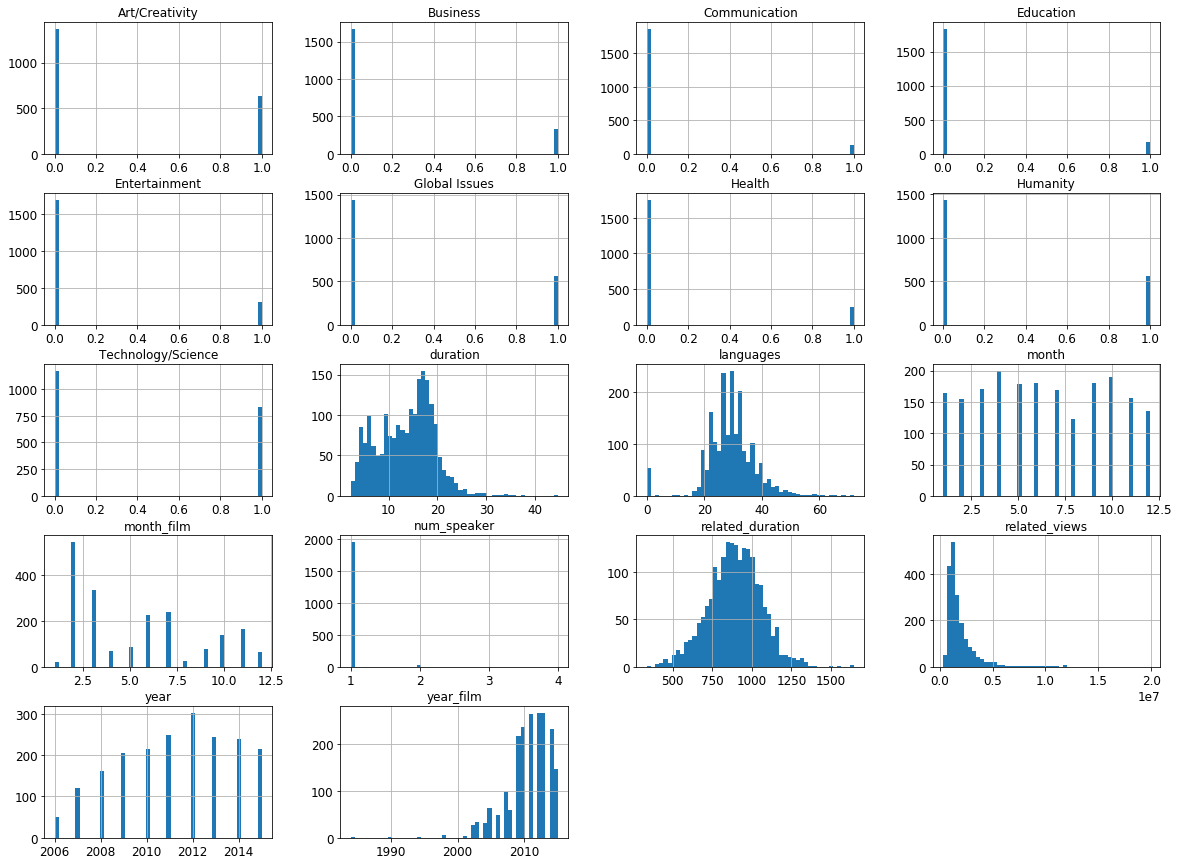

In [84]:
# Plot some train_copy histograms

train_copy.hist(bins=50, figsize=(20,15))
plt.show()

,num_speaker,duration,languages,related_views
num_speaker,1.000000,-0.032088,-0.035246,-0.014353
duration,-0.032088,1.000000,-0.316973,-0.003139
languages,-0.035246,-0.316973,1.000000,0.195044
related_views,-0.014353,-0.003139,0.195044,1.000000


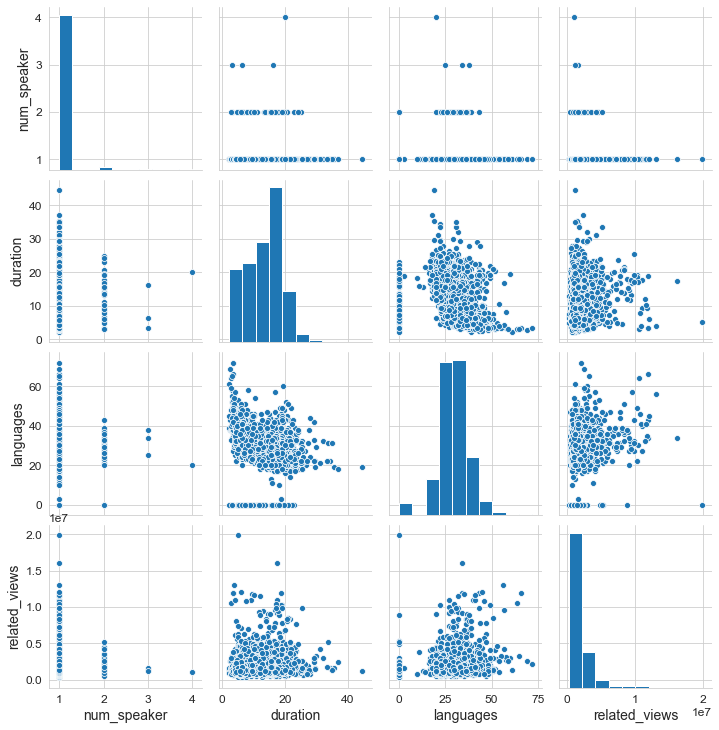

In [85]:
# Lets check for correlation

import seaborn as sns
from seaborn import pairplot
sns.set_style("whitegrid")

sns.pairplot(data=train_copy, vars=["num_speaker", "duration", "languages","related_views"])
display(train_copy[["num_speaker", "duration", "languages","related_views"]].corr())

* From the correlation table and pair plot, we can see that related_views and languages have a corr factor of 0.18, suggesting low to medium correlation.
* While duration have very weak correlation to views, number of speakers and different languages, suggesting longer talks don't seem to gather more attention from the audience.

## TED's categories: differents durations and views

Lets see how duration and views fluctuate through categories.

### Duration per category

Average duration = 13.6
Median duration = 14.38


,event_category,duration
201,TED1900s,44.63
224,TED2000s,37.03
179,TED2000s,35.47
1599,TED2000s,35.03
40,TED2000s,34.42
329,TEDGlobal,33.63
1602,TED2000s,33.50
89,TED2000s,32.15
269,TED2000s,31.13
150,TED2000s,29.85


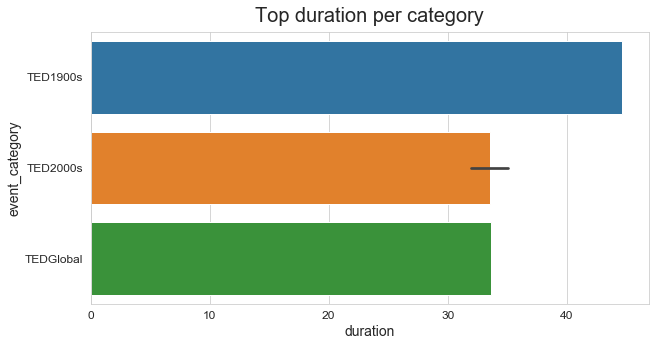

In [86]:
print("Average duration = {}".format(round(train_copy["duration"].mean(), 2)))
print("Median duration = {}".format(round(train_copy["duration"].median(), 2)))

display(train_copy[["event_category", "duration"]].sort_values("duration", ascending=False).head(10))

plt.figure(figsize=(10,5))
ax = sns.barplot(x="duration", y="event_category", data=train_copy.sort_values('duration', ascending=False)[:10])
ax.set_title("Top duration per category", pad=10, fontdict={'fontsize': 20})
plt.show()


* Knowing that on an average most TED talks are usually about 18 mins long, __average of 13.6 mins__ and __median of 14.1 mins__ for the entore dataset seems a little lower.

* TEDOther seems to be the most popular type of event. Infact most of the top duration talks aren't TED talks as seen from the _event_ column. These talks were just hosted on ted.com website.

* Having talks that over an hour are uncommon.

### Views per category

Average views = 1989730.25
Median views = 1470634.0


,event_category,related_views
1097,TEDOther,19871074
1814,TEDx,16127339
429,TED2000s,13065269
1849,TEDGlobal,12032103
321,TED2000s,11944922
301,TED2000s,11903226
47,TED2000s,11888126
864,TED2000s,11843988
1783,TEDx,11678706
1734,TED@,11453815


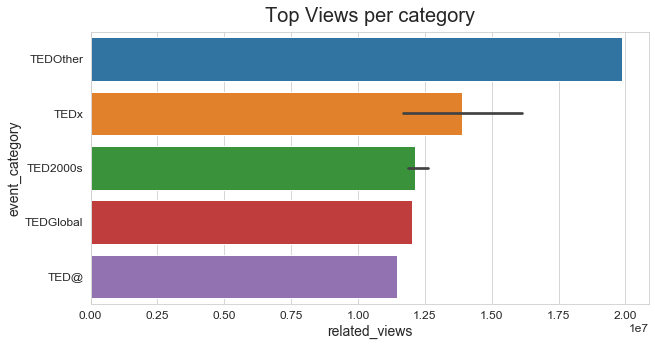

In [87]:
xprint("Average views = {}".format(round(train_copy["related_views"].mean(), 2)))

print("Median views = {}".format(round(train_copy["related_views"].median(), 2)))

display(train_copy[["event_category", "related_views"]].sort_values('related_views', ascending=False).head(10))

plt.figure(figsize=(10,5))
ax = sns.barplot(x="related_views", y="event_category", data=train_copy.sort_values('related_views', ascending=False)[:10])
ax.set_title("Top Viewsx per category", pad=10, fontdict={'fontsize': 20})
plt.show()

* The most views came from TEDOther events, with almost 20 million views, which is huge when compared to average views of about 1.7 million, and a median of about 1.12 million.
* At second place is TEDx with more than 12.5 million views.

## Talks over years and months

How are the talks distributed throughout time since its creation?

### Years

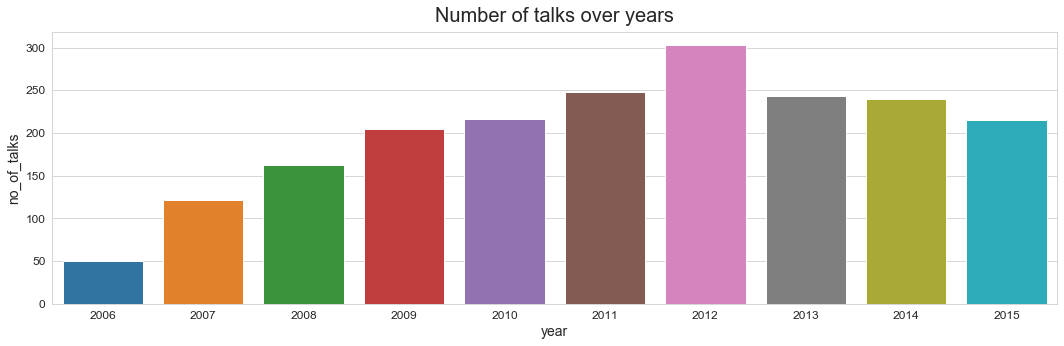

In [88]:
talk_years = train_copy['year'].value_counts().reset_index()
talk_years.columns = ["year", "no_of_talks"]

plt.figure(figsize=(18,5))
ax = sns.barplot(x="year", y="no_of_talks", data=talk_years)
ax.set_title("Number of talks over years", pad=10, fontdict={'fontsize': 20})
plt.show()

* Number of talks increased consistently from 2006 to 2012 and then stabilized. 

### Months

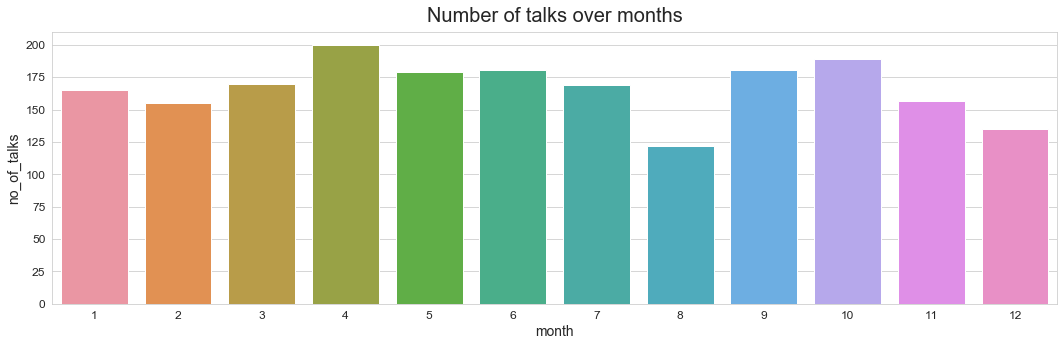

In [92]:
talk_month = train_copy['month'].value_counts().reset_index()
talk_month.columns = ["month", "no_of_talks"]

plt.figure(figsize=(18,5))
ax = sns.barplot(x="month", y="no_of_talks", data=talk_month)
ax.set_title("Number of talks over months", pad=10, fontdict={'fontsize': 20})
plt.show()

#1 = january ; 12 = December

---

# IV - Select and train a model 

In [93]:
#Import models' packages
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


#Regression Models
regression_models = [['Linear Regression',LinearRegression()], 
                     ['RF regressor',RandomForestRegressor()], 
                     ['GBT',GradientBoostingRegressor()],
                     ['LASSO', Lasso()],
                     ['Ridge', Ridge()]]
                     

MSEs = []
Models = ['Linear Regression', 'Random Forest Regressor', 'Gradient Boosting Regressor', 'Lasso', 'Ridge']

for name, model in regression_models: 
    print('Model = ', name)
    model.fit(train_prepared, train_labels.values.ravel())
    #model.fit(train_prepared, train_labels.values.ravel()) if we have trouble fitting the models, use this line
    y_predictor = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    MSE = mean_squared_error(train_labels, ted_view_preds)
    MSEs.append(MSE)
    print("MSE: ", MSE)
    print("-" * 19)

Model =  Linear Regression


NameError: name 'X_test' is not defined

In [91]:
####
####



### didnt want to delete but not sure we should keep whats under here or not !!!!

In [54]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_prepared, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [55]:
some_data = train_copy.iloc[:5]
some_labels = train_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [1559493.16042306 1307600.13904069 2183881.64578439 1338371.89686243
 2391655.42513571]


In [56]:
from sklearn.metrics import mean_squared_error

ted_view_preds = lin_reg.predict(train_prepared)
lin_mse = mean_squared_error(train_labels, ted_view_preds)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

2339808.7815086776

In [57]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(train_prepared, train_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [58]:
ted_view_preds = tree_reg.predict(train_prepared)
tree_mse = mean_squared_error(train_labels, ted_view_preds)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [59]:
print("Predictions:", tree_reg.predict(some_data_prepared))

Predictions: [1219828. 1324704.  923663. 1110781. 1258574.]


# V - Clustering Model

In [113]:
#Importing required modules
 
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np

pca = PCA(2)
 
#Transform the data
df = pca.fit_transform(train_cluster)
 
df.shape

(2003, 2)

In [114]:
train_cluster = train_copy.drop(["event_category","day","day_film"],axis=1)

In [115]:
train_cluster

,num_speaker,duration,languages,related_views,related_duration,month,year,month_film,year_film,Technology/Science,Humanity,Global Issues,Art/Creativity,Business,Entertainment,Health,Communication,Education
0,1,19.40,60,3027062,921,6,2006,2,2006,0,1,0,1,0,0,0,0,1
1,1,16.28,43,1118767,1096,6,2006,2,2006,1,1,1,0,0,0,0,0,0
2,1,21.43,26,1846195,915,6,2006,2,2006,1,0,0,0,0,1,0,0,0
3,1,18.60,35,776189,748,6,2006,2,2006,0,0,1,0,1,0,0,0,0
4,1,19.83,48,1907337,943,6,2006,2,2006,0,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998,1,8.82,27,2060572,685,12,2015,11,2014,0,1,0,0,0,0,0,0,0
1999,2,15.73,29,1660386,879,12,2015,5,2015,0,1,1,1,0,0,0,0,0
2000,1,19.90,30,1283705,924,12,2015,12,2015,0,0,0,0,0,1,0,0,0
2001,1,9.47,23,1963576,1150,12,2015,6,2015,0,0,0,0,0,0,0,0,0


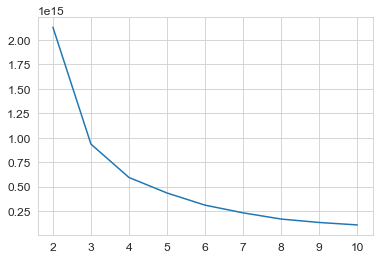

In [116]:
#Elbow Method
from sklearn.cluster import KMeans
withinss = []
for i in range(2,11):
    kmeans = KMeans(n_clusters=i)
    model_clustering = kmeans.fit(train_cluster)
    withinss.append(model_clustering.inertia_)  
    
from matplotlib import pyplot
pyplot.plot([2,3,4,5,6,7,8,9,10],withinss)    
#the optimal number of clusters is 5

In [117]:
#Optimal number of clusters seems to be at 6

In [119]:
from sklearn.cluster import KMeans    
kmeans = KMeans(n_clusters=6)    
model_clustering = kmeans.fit(df)
labels = model_clustering.predict(df)    

from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
silhouette_score(df,labels)
silhouette=silhouette_samples(df,labels)
np.average(silhouette)

0.5861133188381543

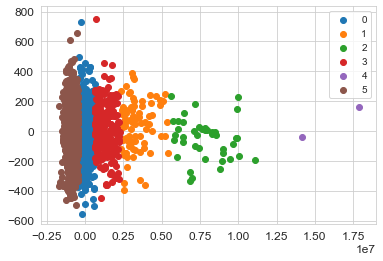

In [121]:
import matplotlib.pyplot as plt

#Getting unique labels
 
u_labels = np.unique(labels)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(df[labels == i , 0] , df[labels == i , 1] , label = i)
plt.legend()
plt.show()

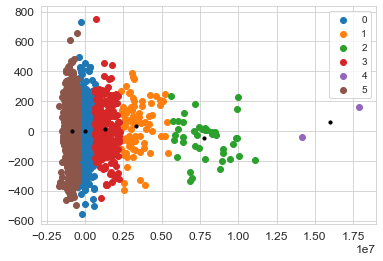

In [129]:
#Getting the Centroids

centroids = kmeans.cluster_centers_
u_labels = np.unique(labels)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(df[labels == i , 0] , df[labels == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 10,color="black")
plt.legend()
plt.show()